# 05 — Evaluation & Interpretation

**Purpose:** Summarize CV and hold‑out performance, prefer Ridge diagnostics if available, and show feature-importance views for RF and Ridge with non‑lag focus.

**Inputs:**
- `./reports/metrics/cv_summary.csv`, `cv_summary_ridge.csv` (optional)
- `./reports/predictions/cv_predictions.csv`
- `./reports/metrics/holdout_metrics.csv`, `holdout_metrics_ridge.csv` (optional)
- `./reports/predictions/holdout_predictions.csv`, `holdout_predictions_ridge.csv` (optional)
- `./reports/metrics/holdout_permutation_importance.csv` (optional)
- `./reports/predictions/residuals_all_data.csv` (optional)
- `./reports/metrics/holdout_shap_mean_abs.csv` (optional)

**Outputs:** none

## 1) Load artifacts

In [1]:
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5); plt.rcParams["figure.dpi"] = 120

BASE = Path("./reports"); MET, PRED = BASE/"metrics", BASE/"predictions"

def sread(p):
    try:
        if p.exists(): return pd.read_csv(p)
    except Exception as e:
        print("Read failed:", p, e)
    return None

# Metrics
rf_cv = sread(MET/"cv_summary.csv")
rg_cv = sread(MET/"cv_summary_ridge.csv")
rf_ho = sread(MET/"holdout_metrics.csv")
rg_ho = sread(MET/"holdout_metrics_ridge.csv")

# Predictions
rf_ho_p = sread(PRED/"holdout_predictions.csv")
rg_ho_p = sread(PRED/"holdout_predictions_ridge.csv")

# Importance
imp_rf = sread(MET/"holdout_permutation_importance.csv")
imp_rg = sread(MET/"holdout_permutation_importance_ridge.csv")
shapabs = sread(MET/"holdout_shap_mean_abs.csv")  # typically RF

## 2) Executive summary

In [2]:
def summary_line(df, label):
    if df is None or df.empty: return None
    r = df.iloc[0]
    return f"{label}: R² {float(r['R2']):.3f}; MAE {float(r['MAE']):.1f}; RMSE {float(r['RMSE']):.1f} ({r.get('years','hold-out')})"

lines = []
if rf_cv is not None and not rf_cv.empty:
    m = rf_cv[pd.to_numeric(rf_cv["fold"], errors="coerce").notna()][["R2","MAE","RMSE"]].astype(float)
    lines.append(f"RF CV: R² {m['R2'].mean():.3f} ± {m['R2'].std():.3f}; MAE {m['MAE'].mean():.1f}; RMSE {m['RMSE'].mean():.1f}")
if rg_cv is not None and not rg_cv.empty:
    m = rg_cv[pd.to_numeric(rg_cv["fold"], errors="coerce").notna()][["R2","MAE","RMSE"]].astype(float)
    lines.append(f"Ridge CV: R² {m['R2'].mean():.3f} ± {m['R2'].std():.3f}; MAE {m['MAE'].mean():.1f}; RMSE {m['RMSE'].mean():.1f}")
if rf_ho is not None and not rf_ho.empty:
    lines.append(summary_line(rf_ho, "RF Hold-out"))
if rg_ho is not None and not rg_ho.empty:
    lines.append(summary_line(rg_ho, "Ridge Hold-out"))

print("\n".join(lines) if lines else "No metrics available.")

RF CV: R² 0.978 ± 0.026; MAE 29.6; RMSE 303.5
Ridge CV: R² 0.975 ± 0.011; MAE 158.7; RMSE 347.3
RF Hold-out: R² 0.993; MAE 29.3; RMSE 280.1 (2018-2022)
Ridge Hold-out: R² 0.979; MAE 228.0; RMSE 496.4 (2018-2022)


## 3) Hold‑out diagnostics (prefer Ridge, else RF)

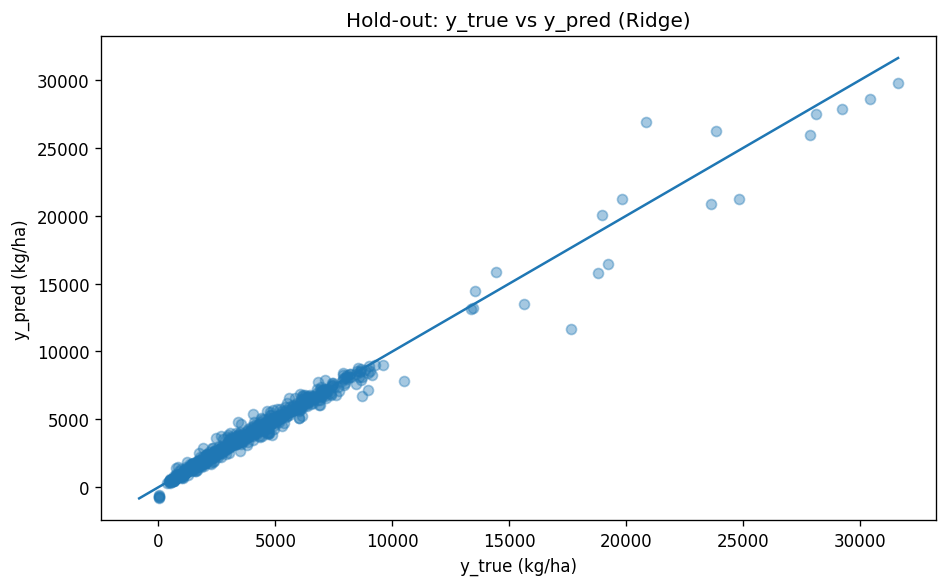

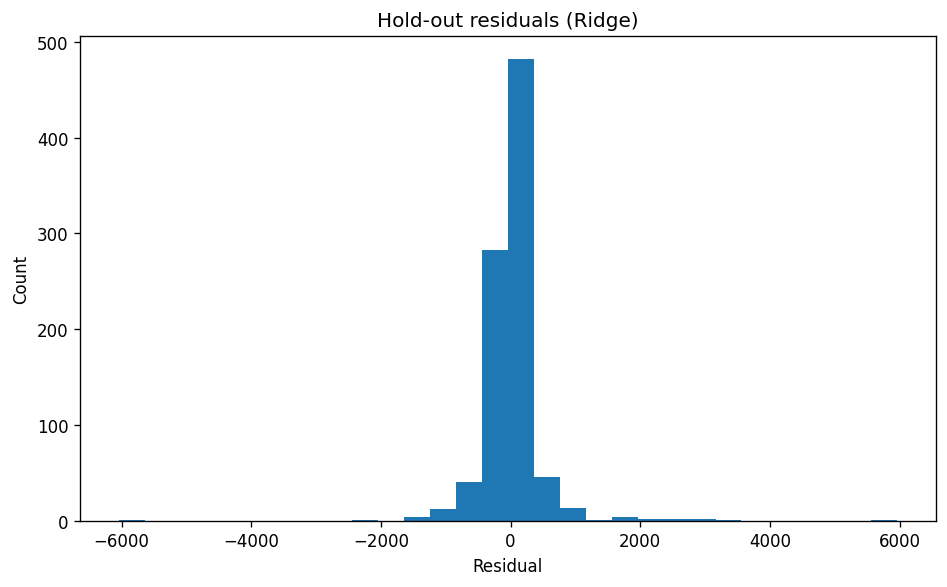

In [3]:
pred_df = None; model_name = None

if rg_ho_p is not None and not rg_ho_p.empty:
    pred_df = rg_ho_p.copy(); model_name = "Ridge"
elif rf_ho_p is not None and not rf_ho_p.empty:
    pred_df = rf_ho_p.copy(); model_name = "Random Forest"

if pred_df is None:
    print("No hold-out predictions found for Ridge or RF.")
else:
    import numpy as np
    x = pred_df["y_true"].to_numpy(dtype=float)
    y = pred_df["y_pred"].to_numpy(dtype=float)

    plt.figure(); plt.scatter(x, y, alpha=0.4)
    lim = [np.nanmin([x.min(), y.min()]), np.nanmax([x.max(), y.max()])]
    plt.plot(lim, lim); plt.xlabel("y_true (kg/ha)"); plt.ylabel("y_pred (kg/ha)")
    plt.title(f"Hold-out: y_true vs y_pred ({model_name})")
    plt.tight_layout(); plt.show()

    resid = x - y
    plt.figure(); plt.hist(resid, bins=30)
    plt.title(f"Hold-out residuals ({model_name})"); plt.xlabel("Residual"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

## 4) Feature importance — non‑lag focus and category summaries

In [4]:
def is_lag_or_roll(feat: str) -> bool:
    f = str(feat)
    if f.startswith("cereal_yield"):   # exclude yield lags/rolls explicitly
        return True
    return ("_lag" in f) or ("_roll" in f)

def feature_category(feat: str) -> str:
    f = feat.lower()
    if "temp" in f: return "Climate: temperature"
    if "precip" in f: return "Climate: precipitation"
    if "fertilizer" in f: return "Inputs: fertilizer"
    if "gdp" in f: return "Macro: income"
    if "co2" in f: return "Macro: emissions"
    if "rural_pop" in f or "population" in f: return "Demography"
    return "Other"

def show_nonlag(df, value_col, label):
    if df is None or df.empty:
        print(f"{label}: not available."); return None
    tbl = df[~df["feature"].apply(is_lag_or_roll)].copy().sort_values(value_col, ascending=False)
    print(label + " — top non-lag features:"); display(tbl.head(15))
    return tbl

def cat_table(df, value_col, label):
    if df is None or df.empty: return
    tab = (df.assign(category=df["feature"].apply(feature_category))
             .groupby("category", as_index=False)[value_col].mean()
             .sort_values(value_col, ascending=False))
    print(label + " — category averages:"); display(tab)

perm_rf_nonlag = show_nonlag(imp_rf, "perm_importance", "RF Permutation importance")
perm_rg_nonlag = show_nonlag(imp_rg, "perm_importance", "Ridge Permutation importance")

if shapabs is not None and not shapabs.empty:
    shap_nonlag = shapabs[~shapabs["feature"].apply(is_lag_or_roll)].copy()                     .sort_values("mean_abs_shap", ascending=False)
    print("RF SHAP (mean |SHAP|) — top non-lag features:")
    display(shap_nonlag.head(15))
else:
    print("RF SHAP: not available.")

cat_table(perm_rf_nonlag, "perm_importance", "RF permutation")
cat_table(perm_rg_nonlag, "perm_importance", "Ridge permutation")

RF Permutation importance — top non-lag features:


,feature,perm_importance
0,log_cereal_yield,1.910259
2,log_fertilizer_use,0.000022
3,fertilizer_use,0.000017
4,temp_anomaly,0.000002
5,is_aggregate,0.000000
7,fertilizer_use_sq,-0.000002
9,temp_anomaly_sq,-0.000010
10,precipitation,-0.000013
14,co2_per_capita,-0.000042
15,tempXprecip,-0.000061


Ridge Permutation importance — top non-lag features:


,feature,perm_importance
2,log_cereal_yield,5.905127e-03
3,precipitation_sq,1.773424e-03
6,fertilizer_use,6.057631e-04
8,precipitation,2.637793e-04
10,arable_land_pct,1.138771e-04
11,temp_anomaly_sq,4.176838e-05
12,co2_total_mt,3.614986e-05
13,gdp_per_capita,1.989916e-05
15,fertilizer_use_sq,7.402683e-06
16,rural_pop_pct,6.369977e-06


RF SHAP: not available.
RF permutation — category averages:


,category,perm_importance
6,Other,0.636693
1,Climate: temperature,-0.000044
3,Inputs: fertilizer,-0.000092
5,Macro: income,-0.000199
0,Climate: precipitation,-0.000282
4,Macro: emissions,-0.000570
2,Demography,-0.000907


Ridge permutation — category averages:


,category,perm_importance
6,Other,2.006335e-03
0,Climate: precipitation,6.807070e-04
3,Inputs: fertilizer,1.540980e-04
1,Climate: temperature,9.085688e-06
5,Macro: income,7.865245e-06
2,Demography,4.778488e-06
4,Macro: emissions,6.737016e-07


## 5) Notes & environment

In [5]:
import sys, platform, numpy, pandas, matplotlib
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.12.11
Platform: macOS-15.6.1-arm64-arm-64bit
NumPy: 2.3.3
Pandas: 2.3.3
Matplotlib: 3.10.6
